# Rainy days on the stock market

Dataproject by Josefine Pedersen, Viktor Texel and Pernille Svendsen

> **Table of contents** 
> - Import and set magics
> - Introduction
> - Read and clean data from DMI and Yahoo Finance
> - Merging the datasets
> - Exploring the datasets
> - Analysis
> - Conclusion

**For nu er rækkefølgen ændret så vi merger før vi explorer, da vi bruger et data fra merge i vores explore**

*Imports and set magics:*

In [1]:
# Import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import requests # library for making HTTP requests
import datetime as dt # library for handling date and time objects
from PIL import Image

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# User written modules
import dataproject

# Installation and import of data-specific tools and packages

# We install a package to inspect data from DMI (The Danish Meteorological Institute):
#%pip install dmi-open-data

# We install nescesarry packages from Yahoo Finance

#%pip install yfinance
#%pip install yahoofinancials

import yfinance as yf

from yahoofinancials import YahooFinancials

# Introduction

In this dataproject we wish to explore if there could be a correlation between weather and developments on the stock market. Through API's we import datasets from DMI and Yahoo Finance to examine whether or not there is a correlation between price fluctuations in the danish OMX C25-index and the amount of precipitation in Denmark. 

To do so, we carefully select comparable data from our datasets, clean it and analyze it using different python-tools. We find that there is litte-to-no correlation between precipitation and fluctuations in the share price of OMX C25 in Denmark.  

# Read and clean data from DMI and Yahoo Finance

In this section we import our data through API's and load it. To do so, the packages *dmi-open data*, *yfinance* and *yfinancials* needs to be installed. These are included at the top in our *import and set magics* section and can be installed by removing the '#' and then running the code. 

**We import data from DMI**:

In [2]:
# We use an API-key given to us from DMI's database to retrieve data
api_key = 'bd463c7d-f6f8-431d-a5a7-c466766a8363'
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

# Issues a HTTP GET request
r = requests.get(DMI_URL, params={'api-key': api_key}) 
print(r)

<Response [200]>


The response [200] means that we have succesfully requested the data. **KAN VI IKKE ÆNDRER DET, SÅ DEN SIGER NOGET MERE SMART - SÅ MAN FX IKKE BEHØVER HAVE DET HER MARKDOWN-FELT?** Vi kan vel bare lade være med at printe r

We examine the data requested and print the available parameters.

In [3]:
# Extract JSON data
json = r.json()

# Print the keys of the JSON dictionary
print(json.keys())

# Convert JSON object to a Pandas DataFrame
df = pd.json_normalize(json['features'])  

df['time'] = pd.to_datetime(df['properties.observed'])

# Generate a list of unique parameter ids
parameter_ids = df['properties.parameterId'].unique() 

# Print all unique parameter ids
print(parameter_ids) 

dict_keys(['type', 'features', 'timeStamp', 'numberReturned', 'links'])
['temp_dew' 'humidity' 'cloud_cover' 'temp_max_past12h' 'pressure_at_sea'
 'wind_speed' 'temp_soil_max_past1h' 'weather' 'wind_dir' 'temp_dry'
 'precip_dur_past10min' 'temp_grass' 'leav_hum_dur_past10min'
 'temp_min_past1h' 'precip_past1min' 'precip_past1h' 'pressure'
 'radia_glob' 'wind_speed_past1h' 'humidity_past1h' 'sun_last10min_glob'
 'precip_past10min' 'visib_mean_last10min' 'leav_hum_dur_past1h'
 'visibility' 'temp_soil' 'temp_soil_min_past1h' 'wind_min'
 'temp_grass_min_past1h' 'wind_min_past1h' 'cloud_height'
 'temp_min_past12h' 'wind_max_per10min_past1h' 'temp_max_past1h'
 'temp_soil_mean_past1h' 'wind_max' 'wind_dir_past1h' 'precip_dur_past1h'
 'temp_grass_mean_past1h' 'wind_gust_always_past1h' 'sun_last1h_glob'
 'temp_mean_past1h' 'radia_glob_past1h' 'temp_grass_max_past1h'
 'snow_depth_man']


From the parameters above, we select the parameter *precip_past1h* which returns the amount of precipitation the last hour in kg/m2 for a given period.

As we have now picked the necessary parameter for our analysis, we have to specify what timeperiod we wanna look at, which DMI-weather stations is relevant to include, and how to structure our DMI-dataset.

We wanna look at the most recent full year, 2022. We specify our timeperiod to start at the first hour of the first day of 2022, and end at the first hour of the first day of 2023. 

DMI has a lot of weatherstations scattered across Denmark, The Faroe Islands and Greenland. These weather stations have different capabilities, and some measure the same as others - meaning there is a risk of having measurements for the geographical location twice. We only wanna look at *Pluvio* stations in Denmark, as these measure precipitation. Therefore we sort our data to only include *Pluvio* station IDs. 

The *Pluvio* stations are located as depicted below:

In [4]:
# Open the image file
img = Image.open("C:/Users/vikto/Documents/A Økonomi/8. Semester/IntroProg/DMI pic.png")

# Convert the image to a NumPy array
img_array = plt.imread("C:/Users/vikto/Documents/A Økonomi/8. Semester/IntroProg/DMI pic.png")

# Show the image in a plot
plt.imshow(img_array)
plt.title('Pluvio stations in Denmark')
plt.xticks([])
plt.yticks([])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/vikto/Documents/A Økonomi/8. Semester/IntroProg/DMI pic.png'

**Man kan ikke se billedet når man kører koden... Du skal lige gemme billedet som en jpg fil i stedet, da den ikke vil læse png**

**I KODEN NEDENUNDER ER DER 2 LIGNINGER DER ER '#' I IF-STATEMENTET - KAN DET SLETTES?** - vi bruger det ikke så jeg tænker ja

In [5]:
# Specify the desired start and end time
start_time = pd.Timestamp(2022, 1, 1)
end_time = pd.Timestamp(2023, 1, 1)

# Specify our selection of station IDs
all_stationsDK = [
    '05005', '05009', '05015', '05031', '05035', '05042', '05065', 
    '05070', '05075', '05081', '05085', '05089', '05095', '05105', 
    '05109', '05135', '05140', '05150', '05160', '05165', '05169', 
    '05185', '05199', '05202', '05205', '05220', '05225', '05269', 
    '05272', '05276', '05277', '05290', '05296', '05300', '05305', 
    '05320', '05329', '05343', '05345', '05350', '05355', '05365', 
    '05375', '05381', '05395', '05400', '05406', '05408', '05435', 
    '05440', '05450', '05455', '05469', '05499', '05505', '05510', 
    '05529', '05537', '05545', '05575', '05735', '05880', '05889', 
    '05935', '05945', '05970', '05986', '05994'
]

# Specify one or more parameter IDs or all_parameters
parameterId = ['precip_past1h']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

dfs = []
for station in all_stationsDK:
    for parameter in parameterId:
        # Specify query parameters
        params = {
            'api-key' : api_key,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '300000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL, params=params)

        # Extract JSON object
        json = r.json()
        
        # Convert JSON object to a MultiIndex DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        if dfi.empty is False:
            dfi['Time'] = pd.to_datetime(dfi['properties.observed'])
            dfi[['station', 'parameter']] = station, parameter
            #dfi = dfi.set_index(['parameter', 'station', 'Time'])
            #dfi = dfi['properties.value'].unstack(['station','parameter'])
            dfi = dfi.set_index(['station', 'Time'])
            dfi = dfi['properties.value'].unstack(['station'])
            dfs.append(dfi)

df = pd.concat(dfs, axis='columns').sort_index()

# Print
df.head()


station,05005,05009,05015,05031,05035,05042,05065,05070,05075,05081,...,05545,05575,05735,05880,05889,05935,05945,05970,05986,05994
Time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.08,0.0
2022-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0


In [6]:
# Alter dobbelt-indexed column
df.reset_index(inplace=True) 
list(df.columns)
df.head()

station,Time,05005,05009,05015,05031,05035,05042,05065,05070,05075,...,05545,05575,05735,05880,05889,05935,05945,05970,05986,05994
0,2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
1,2022-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.08,0.0
2,2022-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
3,2022-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
4,2022-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0


To simplify the data we calculate the average of precipitation across all selected *pluvio* weather stations and store this data.

**Jeg har fjernet 1 warning, men jeg kan ikke komme af med den anden - måske en af jer andre har et bud**

In [12]:
# We create a row-average of the observations across weather stations
df['Precip'] = df.mean(axis=1, numeric_only = True)
df['Date'] = df.Time.dt.date 
df2 = df[['Time', 'Date', 'Precip']] 

# Drop last n rows
df2.drop(df2.tail(1).index, inplace=True) 
df2

/var/folders/12/8qxsq5yd75n7_tx6ptkgmplw0000gn/T/ipykernel_61018/590260095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(df2.tail(1).index, inplace=True)


station,Time,Date,Precip
0,2022-01-01 00:00:00+00:00,2022-01-01,0.008364
1,2022-01-01 01:00:00+00:00,2022-01-01,0.034727
2,2022-01-01 02:00:00+00:00,2022-01-01,0.041296
3,2022-01-01 03:00:00+00:00,2022-01-01,0.015185
4,2022-01-01 04:00:00+00:00,2022-01-01,0.029630
...,...,...,...
8733,2022-12-31 19:00:00+00:00,2022-12-31,0.120656
8734,2022-12-31 20:00:00+00:00,2022-12-31,0.420820
8735,2022-12-31 21:00:00+00:00,2022-12-31,0.611967
8736,2022-12-31 22:00:00+00:00,2022-12-31,0.993770


With 8760 hours in a year we have 22 missing hours. We investigate which days causes the issue.

In [13]:
# We check to see which days have missing hours
tjek = df2.groupby(['Date'])['Time'].count()
tjek = pd.DataFrame(tjek)
tjek

tjek2 = tjek.loc[tjek['Time']!=24]
tjek2

,Time
Date,
2022-06-14,23
2022-06-15,21
2022-06-16,22
2022-06-17,22
2022-06-18,22
2022-06-19,19
2022-06-20,22
2022-06-21,21
2022-06-22,22


To tackle this issue, and to make our precipitation data more easily comparable, we calculate the daily average of the precipitation across weather stations (stored as df2) and store this data as df3. Now we have a dataset that displays the average daily precipitation across Denmark. 

In [15]:
df3 = df2.groupby('Date').mean(numeric_only=True)
df3.reset_index(inplace=True) 
df3['Date'] =pd.to_datetime(df3['Date'])
df3

station,Date,Precip
0,2022-01-01,0.170616
1,2022-01-02,0.186448
2,2022-01-03,0.158633
3,2022-01-04,0.106235
4,2022-01-05,0.121349
...,...,...
360,2022-12-27,0.099927
361,2022-12-28,0.568777
362,2022-12-29,0.214848
363,2022-12-30,0.117192


Illustrating the average precipitation in 2022:

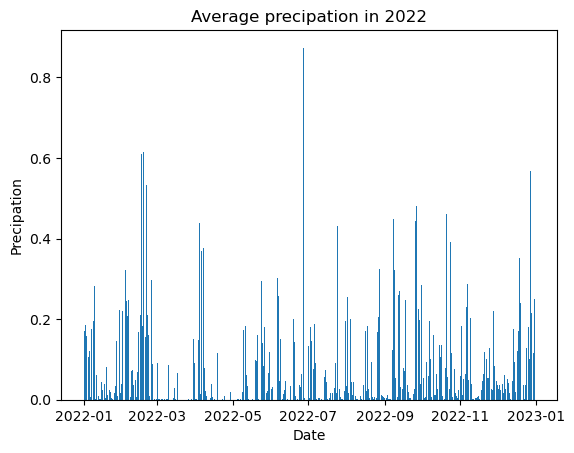

In [16]:
# a. create the figure
fig = plt.figure()

# b. plot
ax = fig.add_subplot(1,1,1)

ax.bar(df3['Date'],df3['Precip'])

ax.set_title('Average precipation in 2022')
ax.set_xlabel('Date')
ax.set_ylabel('Precipation');

We import and clean data from Yahoo Finance

**Jeg har droppet de variable i kan se nedenfor - i kan bare tilføje igen, hvis der er nogen i føler vi skal have med**

In [21]:

OMXC25 = yf.download('^OMXC25', start='2022-01-01', end='2023-01-01', progress=False)
OMXC25.reset_index(inplace=True) 
OMXC25['Date'] =  pd.to_datetime(OMXC25['Date'])

# Cleaning the data from irrelevant variables 
OMXC25.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

OMXC25


,Date,Close
0,2022-01-03,1970.949951
1,2022-01-04,1952.810059
2,2022-01-05,1947.630005
3,2022-01-07,1867.989990
4,2022-01-10,1825.510010
...,...,...
245,2022-12-23,1695.199951
246,2022-12-27,1701.630005
247,2022-12-28,1695.209961
248,2022-12-29,1712.839966


# Merge data sets

We create combinations of our loaded data sets from DMI and Yahoo Finance.

In [23]:
# Merge data
precip_stock = pd.merge(OMXC25, df3, on='Date', how='left')
precip_stock2 = precip_stock[['Date', 'Close', 'Precip']]
precip_stock2


,Date,Close,Precip
0,2022-01-03,1970.949951,0.158633
1,2022-01-04,1952.810059,0.106235
2,2022-01-05,1947.630005,0.121349
3,2022-01-07,1867.989990,0.174461
4,2022-01-10,1825.510010,0.002900
...,...,...,...
245,2022-12-23,1695.199951,0.002511
246,2022-12-27,1701.630005,0.099927
247,2022-12-28,1695.209961,0.568777
248,2022-12-29,1712.839966,0.214848


In [24]:
# We calculate the pct. change from day-to-day on the closing price of OMXC25
precip_stock2['Change_in_stock'] = ((precip_stock2['Close'] / precip_stock2['Close'].shift(1) - 1)* 100)
precip_stock2

,Date,Close,Precip,Change_in_stock
0,2022-01-03,1970.949951,0.158633,NaN
1,2022-01-04,1952.810059,0.106235,-0.920363
2,2022-01-05,1947.630005,0.121349,-0.265262
3,2022-01-07,1867.989990,0.174461,-4.089073
4,2022-01-10,1825.510010,0.002900,-2.274101
...,...,...,...,...
245,2022-12-23,1695.199951,0.002511,0.627434
246,2022-12-27,1701.630005,0.099927,0.379309
247,2022-12-28,1695.209961,0.568777,-0.377288
248,2022-12-29,1712.839966,0.214848,1.039989


We now calculate the 10 days with the most progress/decrease in the share price for the OMXC25

In [26]:
# 10 days with highest changes in the stock price
highest = precip_stock2.nlargest(10,'Change_in_stock') 
highest

,Date,Close,Precip,Change_in_stock
116,2022-06-27,1627.569946,0.873732,4.669573
98,2022-05-30,1702.550049,0.066899,4.050041
26,2022-02-09,1765.050049,0.074717,3.896146
214,2022-11-10,1689.650024,0.039105,3.818742
38,2022-02-25,1713.150024,0.089489,3.369937
39,2022-02-28,1764.810059,0.001019,3.015500
139,2022-07-28,1743.479980,0.001817,2.912998
30,2022-02-15,1742.140015,0.210196,2.910443
187,2022-10-04,1503.920044,0.006535,2.907426
94,2022-05-20,1653.959961,0.095344,2.789811


In [25]:
# 10 days with smallest changes in the stock price 
lowest = precip_stock2.nsmallest(10, 'Change_in_stock')
lowest

,Date,Close,Precip,Change_in_stock
86,2022-05-09,1579.150024,0.018073,-5.015248
3,2022-01-07,1867.989990,0.174461,-4.089073
110,2022-06-16,1514.329956,0.000181,-3.490537
14,2022-01-24,1719.089966,0.002116,-3.450661
85,2022-05-06,1662.530029,0.001922,-3.391830
164,2022-09-01,1598.030029,0.003558,-3.304995
184,2022-09-29,1419.339966,0.197864,-2.873409
13,2022-01-21,1780.530029,0.023261,-2.766502
22,2022-02-03,1768.459961,0.322891,-2.760278
179,2022-09-22,1483.270020,0.003168,-2.651494


In [ ]:
#  Compare with the amount of rain on these days. Is there a correlation?

# Viktor

Looking at monthly data to get a view of trends

In [28]:
precip_stock3 = precip_stock2
precip_stock3['Month'] = precip_stock3.Date.dt.month 
precip_stock4 = precip_stock3.groupby('Month').mean(numeric_only=True)
precip_stock4.reset_index(inplace=True) 
precip_stock3

,Date,Close,Precip,Change_in_stock,Month
0,2022-01-03,1970.949951,0.158633,NaN,1
1,2022-01-04,1952.810059,0.106235,-0.920363,1
2,2022-01-05,1947.630005,0.121349,-0.265262,1
3,2022-01-07,1867.989990,0.174461,-4.089073,1
4,2022-01-10,1825.510010,0.002900,-2.274101,1
...,...,...,...,...,...
245,2022-12-23,1695.199951,0.002511,0.627434,12
246,2022-12-27,1701.630005,0.099927,0.379309,12
247,2022-12-28,1695.209961,0.568777,-0.377288,12
248,2022-12-29,1712.839966,0.214848,1.039989,12


## Explore each data set

We now explore the cleaned data by making graphs and interactive plots

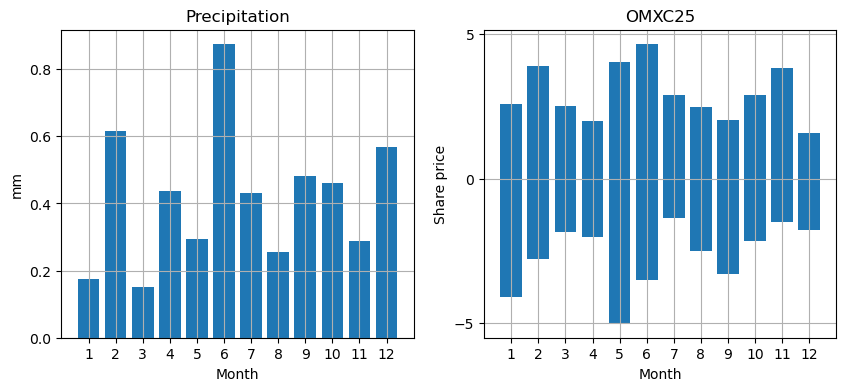

In [38]:
# Creating a figure of the two datasets by month
fig = plt.figure(figsize=(10,4))

# a. Left figure 
ax_left = fig.add_subplot(1,2,1)
ax_left.set_title('Precipitation')
ax_left.grid(True)
ax_left.bar(precip_stock3['Month'],precip_stock3['Precip'])
ax_left.set_xlabel('Month')
ax_left.set_ylabel('mm')
ax_left.set_xlim(0, 13)
ax_left.set_xticks(range(1, 13))

# b. Right figure
ax_right = fig.add_subplot(1,2,2)
ax_right.set_title('OMXC25')
ax_right.grid(True)
ax_right.bar(precip_stock3['Month'],precip_stock3['Change_in_stock'])
ax_right.set_xlabel('Month')
ax_right.set_ylabel('Share price')
ax_right.locator_params(axis='both', nbins=4)
ax_right.set_xlim(0, 13)
ax_right.set_xticks(range(1, 13));

**Interactive plot** :

In [39]:
# Making an interactive figure
def interactive_figure(Date, Month, Change_in_stock, Precip):
    filtered_data = precip_stock3[precip_stock3['Month']==Month]

    fig = plt.figure(figsize=(10,4))

    ax_left = fig.add_subplot(1,2,1)
    ax_left.set_title('Precipitation')
    ax_left.grid(True)
    ax_left.bar(filtered_data['Date'],filtered_data['Precip'])
    ax_left.set_xlabel('Date')
    ax_left.set_ylabel('mm')

    ax_right = fig.add_subplot(1,2,2)
    ax_right.set_title('OMXC25')
    ax_right.grid(True)
    ax_right.bar(filtered_data['Date'],filtered_data['Change_in_stock'])
    ax_right.set_xlabel('Date')
    ax_right.set_ylabel('Share price')

    plt.show()

widgets.interact(interactive_figure,
    Date=widgets.fixed(precip_stock3['Date']),
    Month=widgets.Dropdown(description="Month", options=precip_stock3.Month.unique(), value=1),
    Change_in_stock=widgets.fixed(precip_stock3['Change_in_stock']),
    Precip=widgets.fixed(precip_stock3['Precip'])
);

interactive(children=(Dropdown(description='Month', index=8, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), …

The interactive plot makes it possible to zoom in on one specific month and see how the share price of OMX C25 and the amount of precipitation differs from day to day in each month. 

# Analysis

We now want to check if there is a correlation between the share price of the OMXC25 and the precipitation in 2022. 

In [45]:
from scipy.stats import pearsonr

precip_stock5 = precip_stock2.iloc[1:]

precip = precip_stock5['Precip']
change_in_stock = precip_stock5['Change_in_stock']

#calculation correlation coefficient and p-value between precipitation and the change in OMXC25
correlation_coefficient, p_value = pearsonr(precip, change_in_stock)
print("Correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)

Correlation coefficient: 0.04727134465345979
p-value: 0.457729227154746


The coefficient shows a very weak positive correlation between the precipitation level and the changes in the OMXC25-index.

**De foreslår at vi laver noget summary statistics**
**Yderligere: MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.**

# Conclusion

In this assignment we look at the precipitation level in Denmark in 2022 along with the OMXC25 index. We found that there was slim to no correlation between the variables meaning that the weather most likely does not affect the changes in share prices of the OMXC25. 

IK SLET SE HVOR CUTE !!!!! ok jeg skal nok slette når jeg kigger fredag:(())
**SÅ NUTTET**

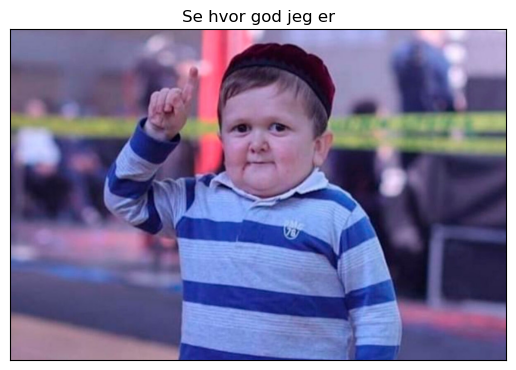

In [3]:
# Open the image file
img = Image.open("C:/Users/vikto/Documents/A Økonomi/8. Semester/IntroProg/16264514660383.jpg")

# Convert the image to a NumPy array
img_array = plt.imread("C:/Users/vikto/Documents/A Økonomi/8. Semester/IntroProg/16264514660383.jpg")

# Show the image in a plot
plt.imshow(img_array)
plt.title('Se hvor god jeg er')
plt.xticks([])
plt.yticks([])
plt.show()